In [1]:
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import time
import wandb

m1 = torch.device("mps")
cpu = torch.device("cpu")

In [2]:
names = open('compiled_names.txt', 'r').read().splitlines()

In [3]:
## functions to convert chars to int and inverse

chars = sorted(list(set(''.join(names))))
stoi = {s:i+1 for i,s in enumerate(chars)}

# . is both "before start" in X, and "im done" for Y
stoi['.'] = 0
itos = {s:i for i,s in stoi.items()}

num_char = len(stoi)

In [4]:
window = 8

def build_dataset(words, device):
    x, y = [], []

    for word in words:
        for i, c in enumerate(word + '.'):
            mini_x = []
            for w in reversed(range(1, window+1)):
                if i - w >= 0:
                    mini_x.append(stoi[word[i-w]])
                else:
                    mini_x.append(stoi['.'])

            x.append(mini_x)
            y.append(stoi[c])
            
    return torch.tensor(x, device=device), torch.tensor(y, device=device)

In [5]:
import random
random.seed(42)
random.shuffle(names)
n1 = int(0.8*len(names))
n2 = int(0.9*len(names))

Xtr, Ytr = build_dataset(names[:n1], device=cpu)
Xdev, Ydev = build_dataset(names[n1:n2], device=cpu)
Xte, Yte = build_dataset(names[n2:], device=cpu)

In [6]:
class MLP(nn.Module):
    def __init__(self, num_char, hidden_nodes, embeddings, window, num_layers):   
        super(MLP, self).__init__()
        
        self.window = window
        self.hidden_nodes = hidden_nodes
        self.embeddings = embeddings        
        
        self.layers = nn.Sequential(
            nn.Embedding(num_char, embeddings),         # [batch, window] --> [batch, window, embeddings]
            nn.Flatten(),                               # [batch, window, embeddings] --> [batch, window*embeddings]
            nn.Linear(embeddings*window, hidden_nodes), # [batch, window*embeddings] --> [batch, hidden_nodes]
            
        )
        for i in range(num_layers):
            if i == 0:
                nodes = window
            else:
                nodes = hidden_nodes
                
            self.layers = self.layers.extend(nn.Sequential(
                nn.Linear(hidden_nodes, hidden_nodes, bias=False),
                nn.BatchNorm1d(hidden_nodes),
                nn.Tanh()))
            
        self.layers = self.layers.extend(nn.Sequential(
            nn.Linear(hidden_nodes, num_char)
        ))
        
        with torch.no_grad():
            self.layers[-1].weight *= 0.1           
        
    def forward(self, x):
        return self.layers(x)

In [13]:
class WaveNet(nn.Module):
    def __init__(self, num_char, hidden_nodes, embeddings, window, num_layers):   
        super(WaveNet, self).__init__()
        
        self.window = window
        self.hidden_nodes = hidden_nodes
        self.embeddings = embeddings        
        
        self.layers = nn.Sequential(
            nn.Embedding(num_char, embeddings)
        )
        
        for i in range(num_layers):
            if i == 0:
                nodes = window
            else:
                nodes = hidden_nodes
                
            self.layers = self.layers.extend(nn.Sequential(
                nn.Conv1d(nodes, hidden_nodes, kernel_size=2, stride=1, bias=False),
                nn.BatchNorm1d(hidden_nodes),
                nn.Tanh()))
            
        self.layers = self.layers.extend(nn.Sequential(
            nn.Flatten(),
            nn.Linear(hidden_nodes*(embeddings-num_layers), num_char)
        ))
        
    def forward(self, x):
        return self.layers(x)

In [11]:
x_test = Xtr[:5]
print("x in\t" + str(x_test.shape))
emb = nn.Embedding(num_char, embeddings)(x_test)
print("emb\t" + str (emb.shape))
conv1 = nn.Conv1d(window, 64, kernel_size=2, stride=2, bias=False)(emb)
print("conv1:\t" + str(conv1.shape))
bn1 = nn.BatchNorm1d(64)(conv1)
tanh1 = nn.Tanh()(bn1)
print("tanh1:\t" + str(tanh1.shape))
conv2 = nn.Conv1d(64, 64, kernel_size=2, stride=2, bias=False)(tanh1)
print("conv2:\t" + str(conv1.shape))
bn2 = nn.BatchNorm1d(64)(conv2)
tanh2 = nn.Tanh()(bn2)
conv3 = nn.Conv1d(64, 64, kernel_size=2, stride=1, bias=False)(tanh2)
print("conv3:\t" + str(conv3.shape))
bn3 = nn.BatchNorm1d(64)(conv3)
tanh3 = nn.Tanh()(bn3)
print("tanh3:\t" + str(tanh3.shape))
flat = nn.Flatten()(tanh3)
print("flat:\t" + str(flat.shape))

x in	torch.Size([5, 8])
emb	torch.Size([5, 8, 10])
conv1:	torch.Size([5, 64, 5])
tanh1:	torch.Size([5, 64, 5])
conv2:	torch.Size([5, 64, 5])
conv3:	torch.Size([5, 64, 1])
tanh3:	torch.Size([5, 64, 1])
flat:	torch.Size([5, 64])


In [14]:
hidden_nodes = 64
embeddings = 10
num_layers = 3

# test_mlp = MLP(num_char, hidden_nodes, embeddings, window, num_layers)
test_mlp = WaveNet(num_char, hidden_nodes, embeddings, window, num_layers)


print(test_mlp.parameters)

# for p in test_mlp.parameters():
#     p.requires_grad = True
    
test_x = Xtr[:20]
test_y = Ytr[:20]

logits = test_mlp(test_x)
loss = F.cross_entropy(logits, test_y)

<bound method Module.parameters of WaveNet(
  (layers): Sequential(
    (0): Embedding(30, 10)
    (1): Conv1d(8, 64, kernel_size=(2,), stride=(1,), bias=False)
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Tanh()
    (4): Conv1d(64, 64, kernel_size=(2,), stride=(1,), bias=False)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Tanh()
    (7): Conv1d(64, 64, kernel_size=(2,), stride=(1,), bias=False)
    (8): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Tanh()
    (10): Flatten(start_dim=1, end_dim=-1)
    (11): Linear(in_features=448, out_features=30, bias=True)
  )
)>


In [15]:
hidden_nodes = 100
embeddings = 10
num_layers = 5

network = WaveNet(num_char, hidden_nodes, embeddings, window, num_layers)
network.to(m1)
network.train(mode=True)

# for p in network.parameters():
#     p.requires_grad = True
    
steps = []
losses = []
dev_steps = []
dev_losses = []
batch_size = 64
max_steps = 200000
rec_freq = 2000
start_time = time.perf_counter()

for i in range(max_steps+1):
    # sample from training set
    sample_idx = torch.randint(len(Ytr), size=(batch_size,1))
    X, Y = torch.squeeze(Xtr[sample_idx].to(m1)), torch.squeeze(Ytr[sample_idx].to(m1))
    
    # forward
    logits = network(X)
    loss = F.cross_entropy(logits, Y)
    
    # zero out grad and do backward pass
    for p in network.parameters():
        p.grad = None
    network.zero_grad()
    loss.backward()
    
    # update
    if i < 40000:
        lr = 0.1
    elif i < 100000:
        lr = 0.01
    else:
        lr = 0.005
    # lr = 0.1 if i < 50000 else 0.01 # step learning rate decay
    with torch.no_grad():
        for p in network.parameters():
            p += -lr*p.grad
        
    steps.append(i)
    losses.append(loss.item())
    
    if i % rec_freq == 0: # print every once in a while
        dev_loss = 0
        with torch.no_grad():
            dev_idx = torch.randint(len(Ydev), size=(batch_size,1))
            X_check, Y_check = torch.squeeze(Xdev[dev_idx].to(m1)), torch.squeeze(Ydev[dev_idx].to(m1))

            dev_loss = F.cross_entropy(network(X_check), Y_check)
            
        current_time = time.perf_counter()
        dt = current_time - start_time
        print(f'{i:7d}/{max_steps:7d}: dt: {dt:.2f} dev_loss: {dev_loss.item():.4f} loss: {loss.item():.4f}')
        
        dev_losses.append(dev_loss.item())
        dev_steps.append(i)

current_time = time.perf_counter()
dt = current_time - start_time
print("total training time: {}".format(dt))

      0/ 200000: dt: 1.90 dev_loss: 3.2249 loss: 3.4736
   2000/ 200000: dt: 27.36 dev_loss: 2.5998 loss: 2.6685
   4000/ 200000: dt: 51.82 dev_loss: 2.5211 loss: 2.2018
   6000/ 200000: dt: 76.23 dev_loss: 2.4387 loss: 2.4146
   8000/ 200000: dt: 100.58 dev_loss: 2.2009 loss: 2.4010
  10000/ 200000: dt: 124.97 dev_loss: 2.4201 loss: 2.2554
  12000/ 200000: dt: 149.48 dev_loss: 2.3210 loss: 2.2272
  14000/ 200000: dt: 174.02 dev_loss: 2.3260 loss: 2.0470
  16000/ 200000: dt: 198.71 dev_loss: 2.1122 loss: 2.3755
  18000/ 200000: dt: 223.10 dev_loss: 2.1416 loss: 2.2384
  20000/ 200000: dt: 247.45 dev_loss: 2.3042 loss: 2.3750
  22000/ 200000: dt: 273.05 dev_loss: 2.1937 loss: 2.2607
  24000/ 200000: dt: 299.08 dev_loss: 2.3152 loss: 2.3009
  26000/ 200000: dt: 324.48 dev_loss: 2.3219 loss: 2.3784
  28000/ 200000: dt: 350.76 dev_loss: 2.1541 loss: 2.1940
  30000/ 200000: dt: 377.08 dev_loss: 2.5851 loss: 2.2420
  32000/ 200000: dt: 402.85 dev_loss: 2.3741 loss: 2.3606
  34000/ 200000: dt

In [19]:
## Save model and params
import yaml

config = {"num_char": num_char,
          "hidden_nodes": hidden_nodes,
          "embeddings": embeddings,
          "window": window,
          "num_layers": num_layers,
          "stoi": stoi}

with open('wavenet_config.yaml', 'w') as file:
    yaml.dump(config, file)
    
print(open('wavenet_config.yaml').read())

# Need to save w/ cpu because spaces doesn't support device('mps')
torch.save(network.to(torch.device("cpu")).state_dict(), "wavenet_weights.pt")

embeddings: 10
hidden_nodes: 100
num_char: 30
num_layers: 5
stoi:
  ' ': 1
  '''': 2
  '-': 3
  .: 0
  a: 4
  b: 5
  c: 6
  d: 7
  e: 8
  f: 9
  g: 10
  h: 11
  i: 12
  j: 13
  k: 14
  l: 15
  m: 16
  n: 17
  o: 18
  p: 19
  q: 20
  r: 21
  s: 22
  t: 23
  u: 24
  v: 25
  w: 26
  x: 27
  y: 28
  z: 29
window: 8



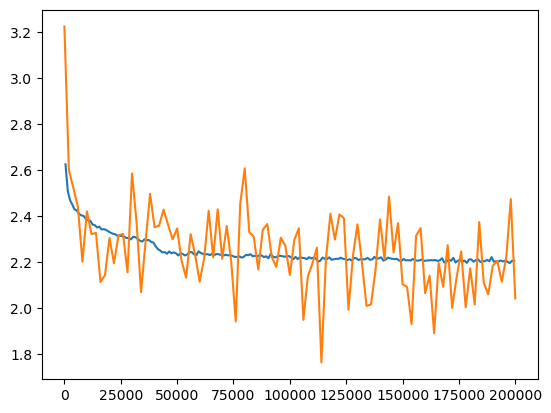

In [16]:
loss_tensor = torch.tensor(losses)
if loss_tensor.shape[0] >= max_steps:
    loss_tensor = loss_tensor[:max_steps]
else:
    loss_tensor = torch.cat((loss_tensor, torch.zeros(max_steps - steps_tensor.shape[0] + 1)), 0)
step_tensor = torch.tensor([a for a in range(loss_tensor.shape[0])], dtype=torch.float32)
loss_tensor = loss_tensor.view(-1, 5).mean(1)
step_tensor = step_tensor.view(-1, 5).mean(1)

plt.plot(step_tensor.view(-1, 200).mean(1), loss_tensor.view(-1, 200).mean(1), label="train loss")
plt.plot(torch.tensor(dev_steps), torch.tensor(dev_losses), label="dev loss")

In [17]:
import gradio as gr

network.to(cpu)

def generate_names(name_start, number_of_names):
    names = ""
    for _ in range((int)(number_of_names)):
    
        # Initialize name with user input
        name = ""
        context = [0] * window
        for c in name_start.lower():
            name += c
            context = context[1:] + [stoi[c]]

        # Run inference to finish off the name
        while True:
            network.eval()
            logits = network(torch.tensor(context).view((1, -1)))
            network.train()

            probs = F.softmax(logits, dim=1)
            ix = torch.multinomial(probs, num_samples=1).item()

            context = context[1:] + [ix]
            name += itos[ix]
            if ix == 0:
                break
            
        names += name + "\n"
        
    return names

demo = gr.Interface(
    fn=generate_names,
    inputs=[
        gr.Textbox(placeholder="Start name with..."),
        "number"
    ],
    outputs="text",
)
demo.launch()

Running on local URL:  http://127.0.0.1:7871

To create a public link, set `share=True` in `launch()`.


[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.
